# Training a Single Layer NN for obtaining weights and biases to be used in the FPGA


In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from pathlib import Path

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [ ]:
try:
  from torchinfo import summary
except:
  print("[INFO] coudln't find torchinfo, installing it...")
  !pip install -q torchinfo
  from torchinfo import summary
  print("[INFO] Done!")

In [ ]:
try:
  import torchmetrics
except:
  print("[INFO] coudln't find torchmetrics, installing it...")
  !pip install -q torchmetrics
  import torchmetrics
  print("[INFO] Done!")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Setup training data
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# Setup testing data
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [ ]:
# See first training sample
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [ ]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Image shape: torch.Size([1, 28, 28])


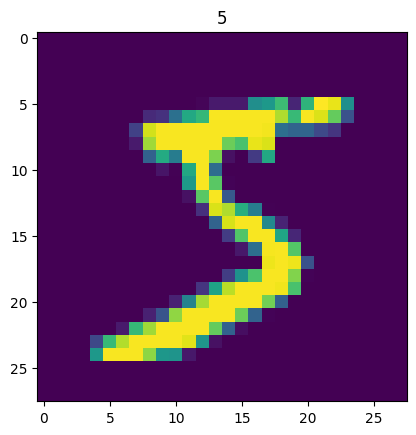

In [ ]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label)
plt.show()

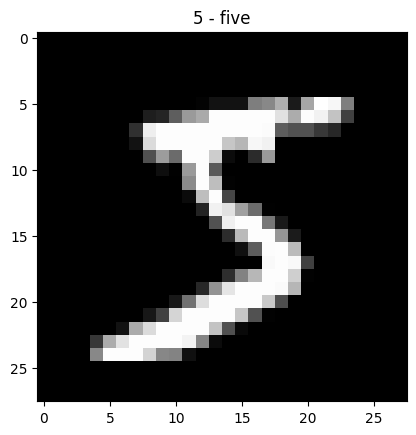

In [ ]:
plt.imshow(image.squeeze(), cmap="grey")
plt.title(class_names[label]);

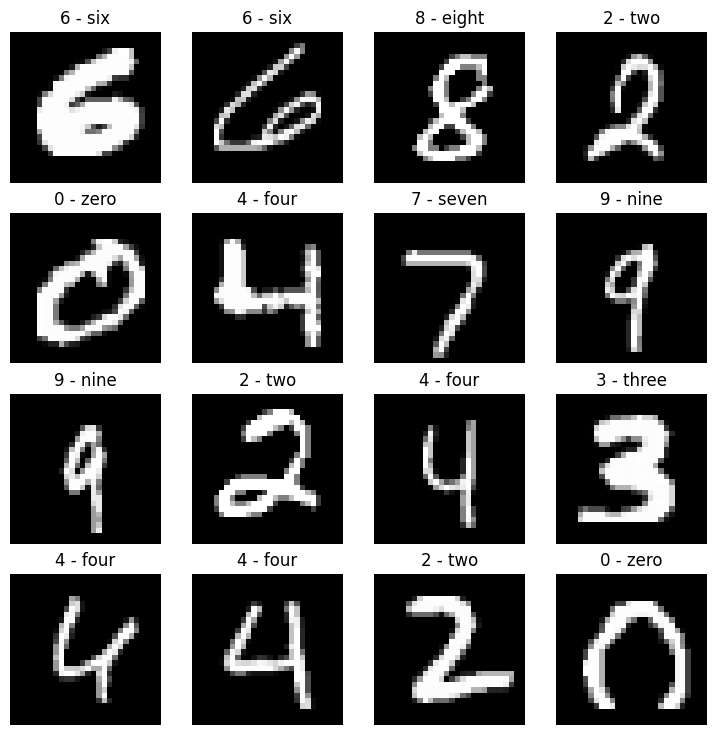

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fbc0b1ff890>, <torch.utils.data.dataloader.DataLoader object at 0x7fbc32ecc550>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
# Create a flatten layer
flatten_model = nn.Flatten()


x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [ ]:
import torch.nn as nn

class MNISTModelSingleLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=28*28, out_features=10)  # 784 → 10
        )

    def forward(self, x):
        return self.layer_stack(x)


In [ ]:
torch.manual_seed(42)

#setup model with input parameters
model_0 = MNISTModelSingleLayer().to(device)


model_0

MNISTModelSingleLayer(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
         [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
         [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
         ...,
         [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
         [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
         [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
          0.0018,  0.0163], requires_grad=True)]

In [ ]:
from torchinfo import summary
summary(model=model_0,
        input_size=(1, 784),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
MNISTModelSingleLayer (MNISTModelSingleLayer)      [1, 784]                  [1, 10]                   --                        True
├─Sequential (layer_stack)                         [1, 784]                  [1, 10]                   --                        True
│    └─Flatten (0)                                 [1, 784]                  [1, 784]                  --                        --
│    └─Linear (1)                                  [1, 784]                  [1, 10]                   7,850                     True
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
from torchmetrics.classification import MulticlassAccuracy

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Instantiate Multiclass Accuracy instance
acc = MulticlassAccuracy(num_classes=len(class_names), average='micro').to(device)
t_acc = MulticlassAccuracy(num_classes=len(class_names), average='micro').to(device)

# Create empty results dictionary
results = {"train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []
}

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 10

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model_0.train()

        # 1. Forward pass
        y_logits = model_0(X)

        # 2. Evaluate the model
        # 2.1 Calculate loss (per batch)
        loss = loss_fn(y_logits, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 2.2 Calculate accuracy (preds need to be same as y_true)
        y_pred_probs = torch.softmax(y_logits, dim=1)
        y_pred_labels = torch.argmax(y_pred_probs, dim=1)
        acc.update(y_pred_labels, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    train_acc = acc.compute().cpu().numpy()

    acc.reset()

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss = 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_logits = model_0(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_logits, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_pred_probs = torch.softmax(test_logits, dim=1)
            test_pred_labels = torch.argmax(test_pred_probs, dim=1)
            t_acc.update(test_pred_labels, y)

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc = t_acc.compute().cpu().numpy()

        t_acc.reset()


    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Train acc: {train_acc:.2f} | Test acc: {test_acc:.2f}%\n")

    # Update results dictionary
    results["train_loss"].append(train_loss.detach().cpu().numpy())
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss.detach().cpu().numpy())
    results["test_acc"].append(test_acc)

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.41364 | Test loss: 0.30824 | Train acc: 0.89 | Test acc: 0.91%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.31355 | Test loss: 0.29060 | Train acc: 0.91 | Test acc: 0.92%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.29657 | Test loss: 0.28118 | Train acc: 0.92 | Test acc: 0.92%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.28817 | Test loss: 0.28172 | Train acc: 0.92 | Test acc: 0.92%

Epoch: 4
-------
Looked at 0/600

In [ ]:
print(model_0)

MNISTModelSingleLayer(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [ ]:
torch.save(model_0.state_dict(), "model_0_weights.pth")


In [ ]:
state_dict = model_0.state_dict()

for name, param in state_dict.items():
    print(f"Layer: {name} | Shape: {param.shape}")
    print(param)

Layer: layer_stack.1.weight | Shape: torch.Size([10, 784])
tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
        [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
        [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
        ...,
        [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
        [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
        [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])
Layer: layer_stack.1.bias | Shape: torch.Size([10])
tensor([-0.7055,  0.5464,  0.2386, -0.4521, -0.0141,  2.0509, -0.2307,  1.0990,
        -2.0980, -0.4122])


In [ ]:
import numpy as np

# Convert a tensor to fixed-point Q8.8 int16 format
def to_fixed_point(tensor, scale=256):  # 2^8 = 256
    return (tensor.cpu().numpy() * scale).astype(np.int16)

# Example: export first layer weights
layer1_w = to_fixed_point(state_dict["layer_stack.1.weight"])
layer1_b = to_fixed_point(state_dict["layer_stack.1.bias"])

In [ ]:
def save_hex(array, filename):
    with open(filename, "w") as f:
        # Convert int16 to uint16 view for proper two's complement hex output
        as_uint16 = array.flatten().astype(np.uint16)
        for val in as_uint16:
            f.write(f"{val:04x}\n")


Generate the files containing the weights and biases for the single layer NN


In [ ]:
layer1_w = to_fixed_point(state_dict["layer_stack.1.weight"])
save_hex(layer1_w, "layer1_weights.hex")

In [ ]:
layer1_b = to_fixed_point(state_dict["layer_stack.1.bias"])
save_hex(layer1_b, "layer1_biases.hex")

# Generate Pixel Data from MNIST Test Set for FPGA Input

In [8]:
import torchvision
import torchvision.transforms as transforms
import torch

transform = transforms.Compose([transforms.ToTensor()])
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Number of images to extract
num_images = 3

label_list = []

for idx in range(num_images):
    image, label = mnist_test[idx]
    label_list.append(label)

    # flatten image and convert to q8.8.
    image_flat = image.view(-1)
    fixed_point_vals = (image_flat * 256).round().clamp(0, 255).short()

    with open(f"mnist_image_{idx}_q8_8.hex", "w") as f:
        for val in fixed_point_vals:
            hex_val = f"{val & 0xFFFF:04x}"
            f.write(f"{hex_val}\n")

# Print labels
for i, label in enumerate(label_list):
    print(f"Image {i} label: {label}")


Image 0 label: 7
Image 1 label: 2
Image 2 label: 1
